<a href="https://colab.research.google.com/github/alex-mcintosh/Supervised-Learning-for-Student-Dropout/blob/main/Applying_supervised_learning_to_predict_student_dropout_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying supervised learning to predict student dropout rate

## **Business context**
Study Group specialises in providing educational services and resources to students and professionals across various fields. The company's primary focus is on enhancing learning experiences through a range of services, including online courses, tutoring, and educational consulting. By leveraging cutting-edge technology and a team of experienced educators, Study Group aims to bridge the gap between traditional learning methods and the evolving needs of today's learners.

Study Group serves its university partners by establishing strategic partnerships to enhance the universities’ global reach and diversity. It supports the universities in their efforts to attract international students, thereby enriching the cultural and academic landscape of their campuses. It works closely with university faculty and staff to ensure that the universities are prepared and equipped to welcome and support a growing international student body. Its partnership with universities also offers international students a seamless transition into their chosen academic environment. Study Group runs several International Study Centres across the UK and Dublin in partnership with universities with the aim of preparing a pipeline of talented international students from diverse backgrounds for degree study. These centres help international students adapt to the academic, cultural, and social aspects of studying abroad. This is achieved by improving conversational and subject-specific language skills and academic readiness before students progress to a full degree programme at university.

Through its comprehensive suite of services, it supports learners and universities at every stage of their educational journey, from high school to postgraduate studies. Its approach is tailored to meet the unique needs of each learner, offering personalised learning paths and flexible scheduling options to accommodate various learning styles and commitments.

Study Group's services are designed to be accessible and affordable, making quality education a reality for many individuals. By focusing on the integration of technology and personalised learning, the company aims to empower learners to achieve their full potential and succeed in their academic and professional pursuits. Study Group is at the forefront of transforming how people learn and grow through its dedication to innovation and excellence.


## Project Aim

A key challenge to Study Group is high student dropout rates, which can harm revenue, reputation, and student satisfaction. This project aims to predict student dropouts using supervised learning models such as XGBoost and neural networks.


# Load libraries and import

In [46]:
# Install and load required libraries
!pip install scikeras -q
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import (roc_auc_score, accuracy_score, f1_score, roc_curve,
                             auc, classification_report, recall_score, precision_score,
                              confusion_matrix, ConfusionMatrixDisplay)
from tensorflow import keras
from keras import layers, Sequential,optimizers
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
import random
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [47]:
# Set random seed
keras.utils.set_random_seed(812)

# Helper Functions

In [48]:
# Create functions for processes that will be used frequently and to keep the
# workbook tidy

def ROC_AUC(predictions, y_test, title):
    # Compute the ROC curve and the AUC score.
    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    auc_score = roc_auc_score(y_test, predictions)
    auc_value = auc(fpr, tpr)

    # Plot the ROC curve and show the AUC score.
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title)
    plt.legend()
    plt.show()

def prepare_data(df, y_var):
    # Split into X and y datasets
    X = df.drop([y_var], axis=1)
    y = df[y_var]
    # Split data into train and test, using stratify due to the class imbalance
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                        random_state=42)
    # One hot encode data
    X_train = pd.get_dummies(X_train, drop_first=True)
    X_test = pd.get_dummies(X_test, drop_first=True)
    # Get columns that are numeric in X_train
    numeric_cols = X_train.select_dtypes(include=['number']).columns
    # Scale numeric values
    scaler = StandardScaler()
    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

    return X_train, X_test, y_train, y_test

def performance_metric(y_test, predictions, title, comparison_df=None):
    print(classification_report(y_test, predictions, digits=4))
    # Calculate and display confustion matrix
    cm = confusion_matrix(y_test, predictions)
    cfmd = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["Completed Course", "Drop Out"])
    fig, ax = plt.subplots(figsize=(4,4))
    cfmd.plot(ax=ax, colorbar=False)
    plt.show()


    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)


    # Create a DataFrame to hold these values
    metrics = pd.DataFrame({
        'Model': [title],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'f1': [f1]
    })

    # Append to existing comparison table
    if comparison_df is not None:
        comparison_df = pd.concat([comparison_df, metrics], ignore_index=True)
    else:
        comparison_df = metrics

    # Display the DataFrame as a table
    display(comparison_df)

    return comparison_df

# Define function to create the neural network model
def create_model(dim, optimizer='adam', neurons=64, activation='relu'):
    model = Sequential()
    model.add(Dense(neurons * 2, input_dim=dim , activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define a function to train the neural network and returen the history
def train_model(model, X_train, y_train, X_val, y_val,
                epochs=50, batch_size=32):
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        verbose=0)
    return history

def create_model_tune(optimizer='Adam', neurons=64, activation='relu', input_dim=None):
    model = Sequential()
    model.add(Dense(neurons * 2, input_dim=input_dim, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Import Data

In [49]:
url = 'https://drive.google.com/uc?id=1rKxv26grdaO6KuN8ZGQX5C-eZ0N6o_hg&export=download'
# Open csv in the 'url' location
df = pd.read_csv(url)
df.head()

,CentreName,AcademicYear,LearnerCode,BookingId,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,...,CreditWeightedAverage,ProgressionDegree,ProgressionUniversity,EligibleToProgress,PresentCount,LateCount,AuthorisedAbsenceCount,UnauthorisedAbsenceCount,ContactHours,AttendancePercentage
0,ISC_Aberdeen,2019/20,2284932,31261386,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,...,75.0,Msc Econ Accounting and Investment Management,University of Aberdeen,Yes,NaN,NaN,NaN,NaN,NaN,NaN
1,ISC_Aberdeen,2019/20,2399500,31979379,Agent,Standard Agent Booking,NaN,12/02/1998,Male,Chinese,...,73.0,BSc Biological Sciences,University of Aberdeen,Yes,80.0,0.0,93.0,5.0,215.0,97.0
2,ISC_Aberdeen,2019/20,2424946,27491184,Agent,Standard Agent Booking,NaN,07/04/2000,Male,Chinese,...,66.0,MA Finance,University of Aberdeen,Yes,88.0,0.0,92.0,6.0,226.0,97.0
3,ISC_Aberdeen,2019/20,2426583,28689190,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,...,71.0,MA Business Management,University of Aberdeen,Yes,164.0,12.0,67.0,15.0,399.0,94.0
4,ISC_Aberdeen,2019/20,2434674,35141670,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,...,60.0,MSc International Business Management,University of Aberdeen,Yes,NaN,NaN,NaN,NaN,NaN,NaN


# Data Wrangling and Exploratory Data Analysis

In [50]:
# Drop columns specified above but leaving ContactHours and AttendancePercentage in place for now
col_list =  ['BookingId','BookingType', 'LeadSource', 'DiscountType',
             'Nationality', 'HomeCountry', 'HomeState', 'HomeCity',
             'PresentCount', 'LateCount', 'AuthorisedAbsenceCount',
             'ArrivedDate','NonCompletionReason', 'TerminationDate',
             'CourseFirstIntakeDate', 'CourseStartDate','CourseEndDate',
             'AcademicYear', 'CourseName', 'LearnerCode', 'ProgressionDegree',
             'EligibleToProgress', 'AssessedModules', 'PassedModules',
             'FailedModules']
# Create reduced dataset
red_df1 = df.drop(col_list, axis=1)
red_df1.head()

,CentreName,DateofBirth,Gender,CourseLevel,IsFirstIntake,CompletedCourse,CreditWeightedAverage,ProgressionUniversity,UnauthorisedAbsenceCount,ContactHours,AttendancePercentage
0,ISC_Aberdeen,13/01/1998,Male,Pre-Masters,True,Yes,75.0,University of Aberdeen,NaN,NaN,NaN
1,ISC_Aberdeen,12/02/1998,Male,Foundation,False,Yes,73.0,University of Aberdeen,5.0,215.0,97.0
2,ISC_Aberdeen,07/04/2000,Male,International Year Two,False,Yes,66.0,University of Aberdeen,6.0,226.0,97.0
3,ISC_Aberdeen,18/05/1999,Male,International Year Two,True,Yes,71.0,University of Aberdeen,15.0,399.0,94.0
4,ISC_Aberdeen,19/04/1996,Male,Pre-Masters,True,Yes,60.0,University of Aberdeen,NaN,NaN,NaN


In [51]:
# Print balance of Course completed to non completed
print(red_df1['CompletedCourse'].value_counts())

CompletedCourse
Yes    21305
No      3754
Name: count, dtype: int64


The classes appear to be imbalanced with $\sim 6\times$ as many students completing the course to not completing the course. This needs to be considered during the analysis.

In [52]:
# Check data for duplicates
print(red_df1.duplicated().sum())

0


In [53]:
# Count number of missing values for each column
print(red_df1.isnull().sum())

CentreName                     0
DateofBirth                    0
Gender                         0
CourseLevel                    0
IsFirstIntake                  0
CompletedCourse                0
CreditWeightedAverage       2296
ProgressionUniversity          0
UnauthorisedAbsenceCount     208
ContactHours                 208
AttendancePercentage         208
dtype: int64


In [54]:
# Check if the 208 missing values in UnauthorisedAbsenceCount,
# AttendancePercentage and ContactHours are in the same rows
print(red_df1[red_df1['UnauthorisedAbsenceCount'].isnull()].isnull().sum())

CentreName                    0
DateofBirth                   0
Gender                        0
CourseLevel                   0
IsFirstIntake                 0
CompletedCourse               0
CreditWeightedAverage       131
ProgressionUniversity         0
UnauthorisedAbsenceCount    208
ContactHours                208
AttendancePercentage        208
dtype: int64


In [55]:
# Print balance of Course completed to non completed
print('Balance of values for UnauthorisedAbsenceCount missing values:')
print(red_df1[red_df1['UnauthorisedAbsenceCount'].isnull()].isnull()['CompletedCourse'].value_counts())
print('Balance of values for ContactHours missing values:')
print(red_df1[red_df1['ContactHours'].isnull()].isnull()['CompletedCourse'].value_counts())
print('Balance of values for AttendancePercentage missing values:')
print(red_df1[red_df1['AttendancePercentage'].isnull()].isnull()['CompletedCourse'].value_counts())

Balance of values for UnauthorisedAbsenceCount missing values:
CompletedCourse
False    208
Name: count, dtype: int64
Balance of values for ContactHours missing values:
CompletedCourse
False    208
Name: count, dtype: int64
Balance of values for AttendancePercentage missing values:
CompletedCourse
False    208
Name: count, dtype: int64


All the missing values appear to be from the class of CompletedCourse = False, which suggests these values may not be missing at random (MNAR). This small number represents only 5.7% of this class. In the interests of pragmatism, these will be removed as imputing for all these fields may add too much complexity at this point for the relative gain in information for keeping them. All 208 missing values are also across the same 208 records, which simplifies their removal. This should be investigated further.



Since the rows with missing values in UnauthorisedAbsenceCount are the same as AttendancePercentage and ContactHours, these will be removed.
These values are also a small subset of the data, only representing  ≈0.8%  of the dataset.

In [56]:
# Remove rows where red_df['UnauthorisedAbsenceCount'].isnull()
red_df1 = red_df1.dropna(subset=['UnauthorisedAbsenceCount'])

In [57]:
# Count number of missing values for each column
print(red_df1.isnull().sum())

CentreName                     0
DateofBirth                    0
Gender                         0
CourseLevel                    0
IsFirstIntake                  0
CompletedCourse                0
CreditWeightedAverage       2165
ProgressionUniversity          0
UnauthorisedAbsenceCount       0
ContactHours                   0
AttendancePercentage           0
dtype: int64


In [58]:
# Filter on CreditWeightedAverage = null value and find out the split in completedcourse
red_df1[red_df1['CreditWeightedAverage'].isnull()]['CompletedCourse'].value_counts()

,count
CompletedCourse,
No,2165


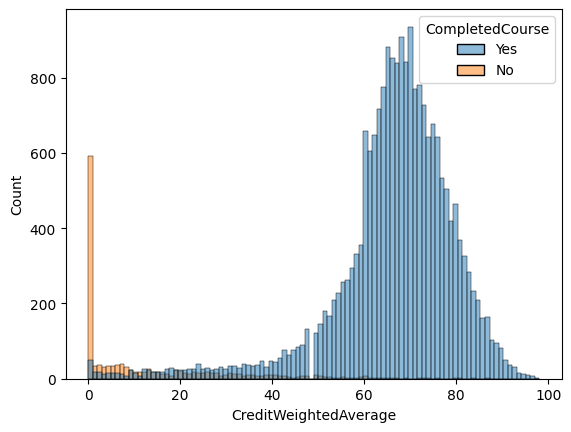

In [59]:
# Plot the distribution of the CreditWeightedAverage by whether the student completed the course or not.
sns.histplot(data=red_df1, x='CreditWeightedAverage', hue='CompletedCourse')
plt.show()

The CreditWeightedAverage values appear to have different distributions depending on whether the student completed the course. Since all the values that are missing are from the CompletedCourse = False class it appears that the values missing from the CreditWeightedAverage column are likely Missing Not at Random (MNAR).

**Removing these would eliminate 60 % of the CompletedCourse = False records and may also introduce bias.**
This needs to be investigated further. Possible approaches to this include:

*   Modelling the 'missing' behaviour
*   Complete removal of this feature

**The missing values will be replaced with the median values for the CompletedCourse = False class in a basic attempt to model the missing behavior. This should be investigated further and considered when assessing the models used**

In [60]:
# Find median value for the false values in 'CreditWeightedAverage' column of red_df1
median_false = red_df1[red_df1['CompletedCourse'] == 'No']['CreditWeightedAverage'].median()
# Replace missing values with the median value for CreditWeightedAverage
red_df1 = red_df1.fillna(median_false)

In [61]:
# Convert DateofBirth to date format
red_df1[['DateofBirth']] = red_df1[['DateofBirth']].apply(pd.to_datetime, format='%d/%m/%Y')
# Create new column called Age and drop date of birth
red_df1['Age'] = (datetime.today() - red_df1['DateofBirth']).dt.days/365.25
red_df1 = red_df1.drop(['DateofBirth'], axis=1)

In [62]:
# Output the number of unique entries for each column
red_df1.nunique()

,0
CentreName,19
Gender,2
CourseLevel,4
IsFirstIntake,2
CompletedCourse,2
CreditWeightedAverage,99
ProgressionUniversity,39
UnauthorisedAbsenceCount,258
ContactHours,658
AttendancePercentage,100


CentreName only has 19 unique values so is okay to one hot encode as is. Progression University needs to be reduced slightly.

In [63]:
# List ProgressionUniversity by number for each unique entry
red_df1['ProgressionUniversity'].value_counts().head(20)

,count
ProgressionUniversity,
University of Sheffield International College,5872
Durham University,2555
University of Sussex,2086
Kingston University London,1859
University of Huddersfield,1752
University of Leeds,1586
Lancaster University,1114
University of Surrey,1047
Royal Holloway,1040


In [64]:
# Arbitarly reduce the number of categories to twenty and relabel the bottom
# categories with less than 100 as 'other'
red_df1['ProgressionUniversity'] = (
    red_df1['ProgressionUniversity'].apply(
        lambda x: 'Other' if red_df1[
            'ProgressionUniversity'
        ].value_counts().get(x, 0) < 100 else x
    )
)

### Histograms of the Features

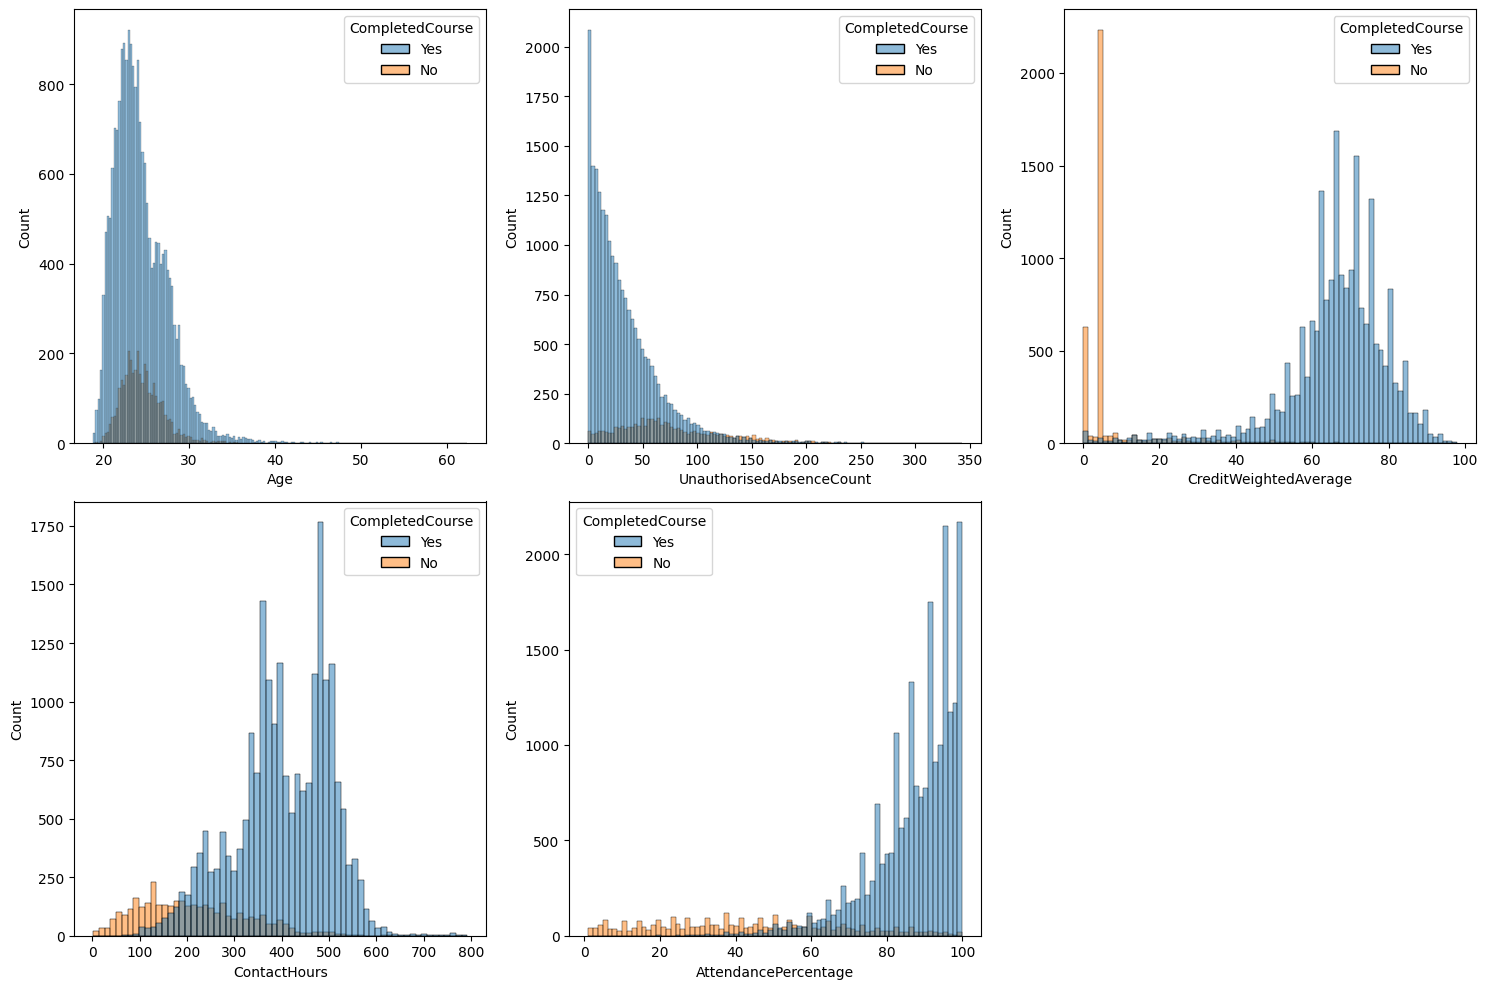

In [65]:
# Plot histogram plots for the each numerical feature
col_names = ['Age',
             'UnauthorisedAbsenceCount',
             'CreditWeightedAverage',
             'ContactHours',
             'AttendancePercentage']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(col_names):
    row = i // 3
    col_num = i % 3
    sns.histplot(data=red_df1, x=col, hue='CompletedCourse', ax=axes[row, col_num])
fig.delaxes(axes[1,2])
plt.tight_layout()
plt.show()

The histograms provide interesting insights into the features of the two classes of CompletedCourse.

**Age** - This appears bimodal for the CompletedCourse = True class, both differences have a right skew. Visually, there is little to separate the classes based on age.

**UnauthorisedAbsenceCount** - These distributions appear to have a Poisson type of distribution, with each class having very different expected values. The CompletedCourse = True having a lower number of unauthorised absences than those who failed to complete the course.

**CreditWeightedAverage** - For the records which completed the course this follows a normal distribution, as would be expected for this type of feature. The distribution for the CompletedCourse = False is very different and it is difficult to determine what distribution would be most effective at modelling this.

**ContactHours** - For the records that completed the course this appears to have a complex multimodal distribution, which may reflect different expectations of contact hours at differenct institutions and courses. For the records which have CompletedCourse = False the average contact hours is much lower and the distribution appears to be unimodal.

**AttendencePercentage** - The two classes in this feature have very different attributes and both could potentially be modelled by a beta distribution.

### Boxplots of the Features

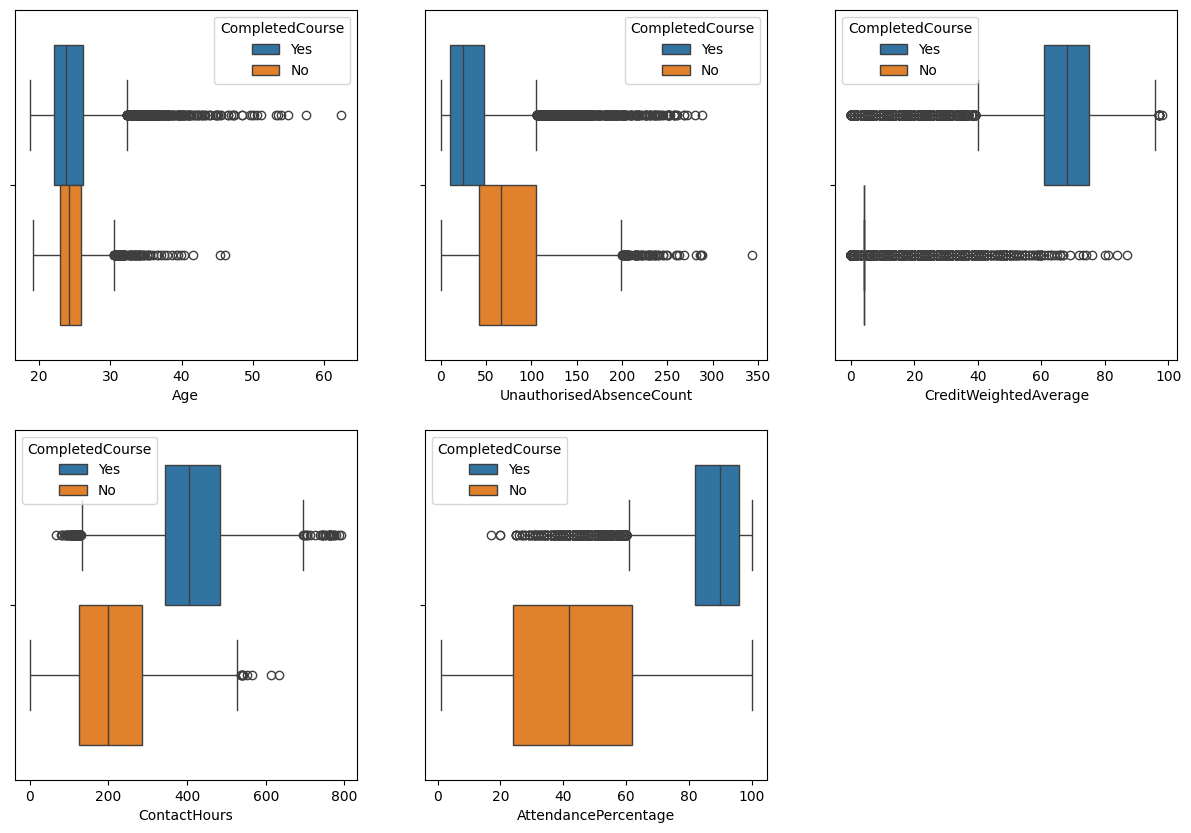

In [66]:
# Plot boxplots for each numerical feature
col_names = ['Age',
             'UnauthorisedAbsenceCount',
             'CreditWeightedAverage',
             'ContactHours',
             'AttendancePercentage']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(col_names):
    row = i // 3
    col_num = i % 3
    sns.boxplot(data=red_df1, x=col, hue='CompletedCourse', ax=axes[row, col_num])
fig.delaxes(axes[1,2])

plt.show()

The boxplots further emphasise the histogram differences between the two classes for each numerical feature. All the features, except Age, have very distinctive differences between the classes. Most features have many outliers, using $1.5 \times IQR$ (the whiskers) as a cut-off. However, it is notable that the CompletedCourse = False class for the attendance percentage did not contain any outliers; for this feature, the difference in variance between the classes is also much larger than for other features.



### Count Plots

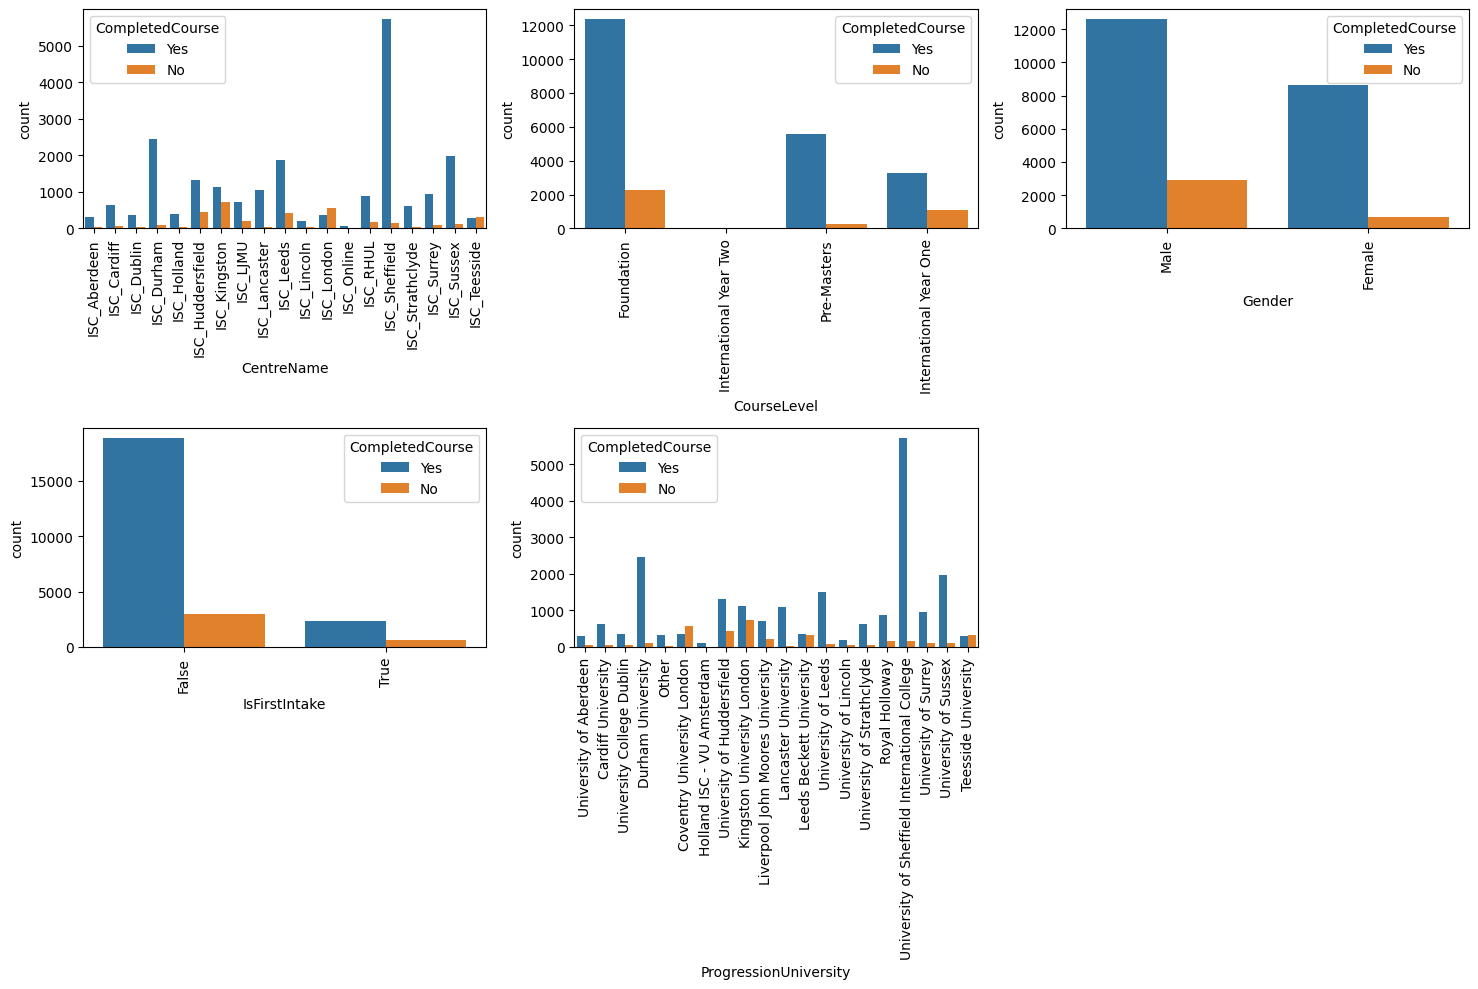

In [67]:
# Plot count plots for each categorical feature
col_names = ['CentreName',
             'CourseLevel',
             'Gender',
             'IsFirstIntake',
             'ProgressionUniversity']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(col_names):
    row = i // 3
    col_num = i % 3
    sns.countplot(data=red_df1, x=col, hue='CompletedCourse', ax=axes[row, col_num])
    axes[row, col_num].set_xticklabels(axes[row, col_num].get_xticklabels(), rotation=90)

fig.tight_layout()
fig.delaxes(axes[1,2])
plt.show()

The categorical data is harder to distinguish. At first, there are differences between the classes. However, some interesting observations show some distinctive features. For example, certain institutions, such as Teesside University and Kingston University London, have relatively high student dropout rates.
It is also noted that visually, many of the trends observed in ProgressionUniversity are also mirrored in the CentreName feature. This suggests a certain amount of colinearity between these features. This should be investigated further, as it may be an opportunity to reduce dimensionality and complexity.

In [68]:
# Convert CompletedCourse to zero and one with the majority class being 0 (Yes) and the minority class being 1 (No)
red_df1['CompletedCourse'] = red_df1['CompletedCourse'].map({'Yes': 0, 'No': 1})
# Rename this to StudentDropOut
red_df1 = red_df1.rename(columns={'CompletedCourse': 'StudentDropOut'})

In [69]:
# Create a new 'minmal' dataset without ContactHours and AttendancePercentage
red_df2 = red_df1.drop(['ContactHours', 'AttendancePercentage'], axis=1)

# XGBoost Model

## XGBoost Model with the Minimal Dataset

Here XGBoost will be used for classification of the Study Group data CentreName, Gender, CourseLevel, IsFirstIntake, CreditWeightedAverage, ProgressionUniversity, UnauthorisedAbsenceCount and Age Features.



In [82]:
# Prepare the train and test set from the minimal dataset red_df2
X_train2, X_test2, y_train2, y_test2 = prepare_data(red_df2, 'StudentDropOut')
# Create a validation train and test data
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2,
                                                      y_train2,
                                                      test_size=0.2,
                                                      stratify=y_train2,
                                                      random_state=42)

XGBoost is first used on the data without any optimisation.

              precision    recall  f1-score   support

           0     0.9801    0.9873    0.9837      4249
           1     0.9219    0.8823    0.9016       722

    accuracy                         0.9720      4971
   macro avg     0.9510    0.9348    0.9427      4971
weighted avg     0.9717    0.9720    0.9718      4971



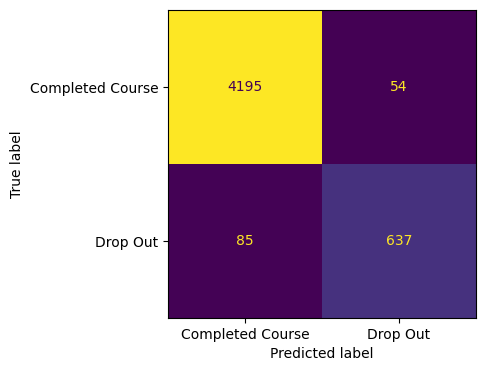

,Model,Accuracy,Precision,Recall,f1
0,XGBoost Model Minimal Dataset,0.972038,0.921852,0.882271,0.901628


In [83]:
xgb_model = xgb.XGBClassifier(random_state=42, eval_set=[(X_val2, y_val2)])
xgb_model.fit(X_train2, y_train2)

predictions = xgb_model.predict(X_test2)
# Plot confustion matrix and performance metrics
model_comparison = None
model_comparison = performance_metric(y_test2, predictions, "XGBoost Model Minimal Dataset", model_comparison)

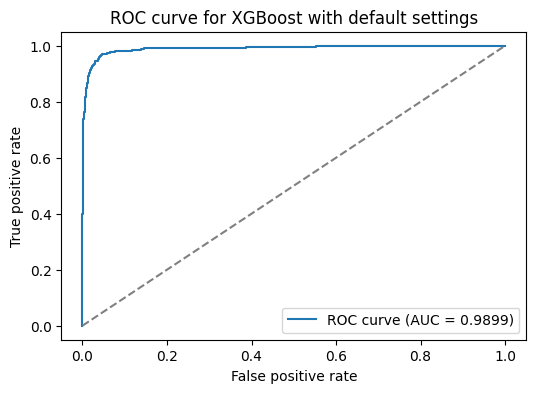

In [85]:
# Predict the probabilities of the positive class on the test set.
y_proba = xgb_model.predict_proba(X_test2)[:, 1]
# Add AUC data to model comparison dataset to last row
model_comparison['AUC'] = float('nan')
model_comparison.iloc[-1, model_comparison.columns.get_loc('AUC')]  = [roc_auc_score(y_test2, y_proba)]
# Plot ROC curve and AUC
ROC_AUC(y_proba, y_test2, 'ROC curve for XGBoost with default settings')

Using default settings the XGBoost produces okay predictions. Due to the class imbalance the F1 score and ROC-AUC will be used as metrics for the models.

### Tuning of the Hyperparameters with the Minimal Dataset

Here, the hyperparameters for the XGBoost model with be tuned using GridSearchCV.

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 75}
Best score:  0.9153146259219365
              precision    recall  f1-score   support

           0     0.9786    0.9887    0.9836      4249
           1     0.9292    0.8726    0.9000       722

    accuracy                         0.9718      4971
   macro avg     0.9539    0.9306    0.9418      4971
weighted avg     0.9714    0.9718    0.9715      4971



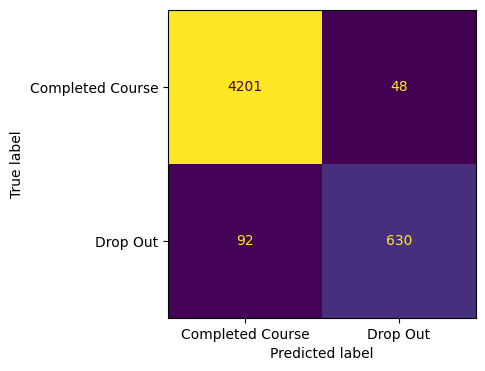

,Model,Accuracy,Precision,Recall,f1,AUC
0,XGBoost Model Minimal Dataset,0.972038,0.921852,0.882271,0.901628,0.989852
1,XGBoost Model Minimal Dataset with Tuning,0.971837,0.929204,0.872576,0.900000,NaN


In [88]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8,],
    'learning_rate': [0.3, 0.2, 0.1],
    'n_estimators': [10, 25, 50, 75, 100]
}

# Create the GridSearchCV object, f1 scoring is used due to the imbalance of the
# dataset
grid_search = GridSearchCV(xgb_model, param_grid, cv=9, scoring='f1')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train2, y_train2)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

predictions = grid_search.predict(X_test2)
# Plot confustion matrix and performance metrics
model_comparison = performance_metric(y_test2, predictions, "XGBoost Model Minimal Dataset with Tuning", model_comparison)

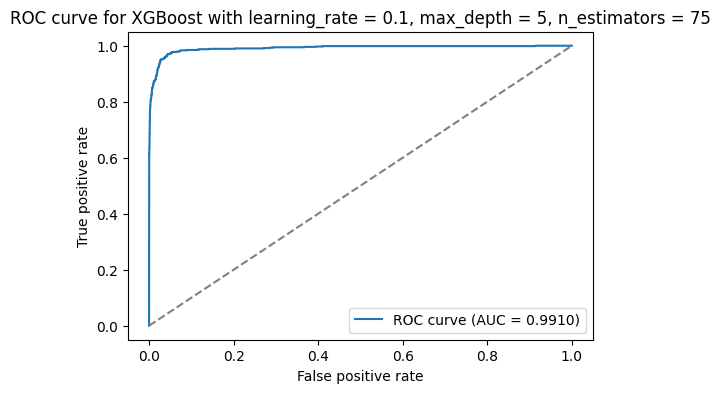

In [90]:
# Predict the probabilities of the positive class on the test set.
y_proba = grid_search.predict_proba(X_test2)[:, 1]
# Add AUC data to model comparison dataset
model_comparison.iloc[-1, model_comparison.columns.get_loc('AUC')]  = [roc_auc_score(y_test2, y_proba)]
# Plot ROC curve and AUC
ROC_AUC(y_proba, y_test2, f"ROC curve for XGBoost with learning_rate = {grid_search.best_params_['learning_rate']}, "
        f"max_depth = {grid_search.best_params_['max_depth']}, "
        f"n_estimators = {grid_search.best_params_['n_estimators']}")

Interestingly slightly worse performance is seen after hyperparameter tuning with GridSearchCV. This likely due to the differences in training the models using crossfold validaiton for GridSearchCV vs the train data set for the 'off-the-shelf' model. This performance difference is marginal and these tuned models may be more robust to new data.

## XGBoost Model with the Extended Dataset

Here, XGBoost will be used to classify the same Study Group data but with the inclusion of the ContactHours and AttendancePercentage features. The 'extended dataset'.

In [92]:
# Create new train and test sets based on the extended dataset which also
# includes ContactHours and AttendencePercentage
X_train1, X_test1, y_train1, y_test1 = prepare_data(red_df1, 'StudentDropOut')
# Create a validation train and test data
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1,
                                                      y_train1,
                                                      test_size=0.2,
                                                      stratify=y_train1,
                                                      random_state=42)

              precision    recall  f1-score   support

           0     0.9855    0.9911    0.9883      4249
           1     0.9456    0.9141    0.9296       722

    accuracy                         0.9799      4971
   macro avg     0.9655    0.9526    0.9589      4971
weighted avg     0.9797    0.9799    0.9797      4971



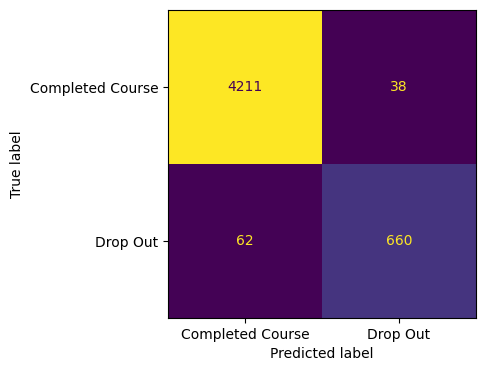

,Model,Accuracy,Precision,Recall,f1,AUC
0,XGBoost Model Minimal Dataset,0.972038,0.921852,0.882271,0.901628,0.989852
1,XGBoost Model Minimal Dataset with Tuning,0.971837,0.929204,0.872576,0.900000,0.990987
2,XGBoost Model Extended Dataset,0.979883,0.945559,0.914127,0.929577,NaN


In [93]:
xgb_model = xgb.XGBClassifier(random_state=42, eval_set=[(X_val1, y_val1)])
xgb_model.fit(X_train1, y_train1)

# Model evaluation
predictions = xgb_model.predict(X_test1)
# Plot confustion matrix and performance metrics
model_comparison = performance_metric(y_test2, predictions, "XGBoost Model Extended Dataset", model_comparison)

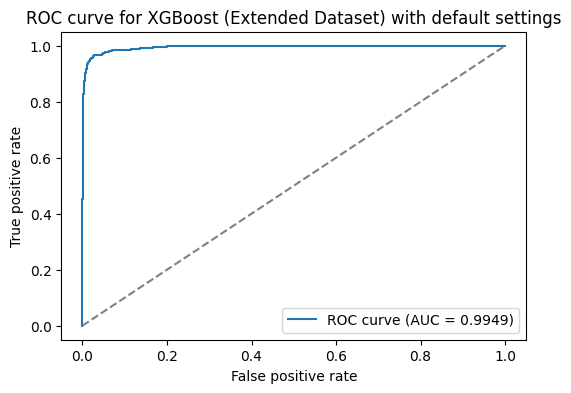

In [94]:
# Predict the probabilities of the positive class on the test set.
y_proba = xgb_model.predict_proba(X_test1)[:, 1]
# Add AUC data to model comparison dataset
model_comparison.iloc[-1, model_comparison.columns.get_loc('AUC')]  = [roc_auc_score(y_test1, y_proba)]
# Plot ROC curve and AUC
ROC_AUC(y_proba, y_test1, 'ROC curve for XGBoost (Extended Dataset) with default settings')

In [95]:
model_comparison

,Model,Accuracy,Precision,Recall,f1,AUC
0,XGBoost Model Minimal Dataset,0.972038,0.921852,0.882271,0.901628,0.989852
1,XGBoost Model Minimal Dataset with Tuning,0.971837,0.929204,0.872576,0.900000,0.990987
2,XGBoost Model Extended Dataset,0.979883,0.945559,0.914127,0.929577,0.994922


The introduction of the additional features positively impacts all the metrics, with increases in all relative to the minimal dataset model.

### Tuning of the Hyperparameters with the Extended Dataset

Here, the hyperparameters for the XGBoost model will be tuned in the same manner as those used for the minimal dataset.

Best set of hyperparameters:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 75}
Best score:  0.9391800528808906
              precision    recall  f1-score   support

           0     0.9843    0.9906    0.9874      4249
           1     0.9424    0.9072    0.9245       722

    accuracy                         0.9785      4971
   macro avg     0.9634    0.9489    0.9560      4971
weighted avg     0.9782    0.9785    0.9783      4971



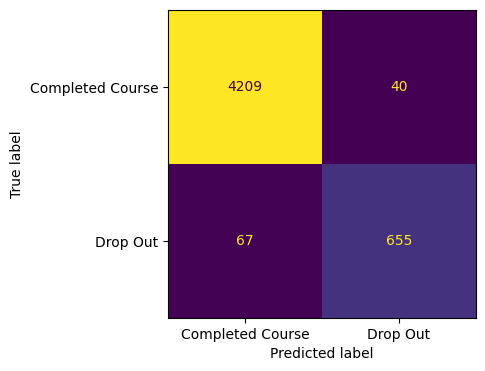

,Model,Accuracy,Precision,Recall,f1,AUC
0,XGBoost Model Minimal Dataset,0.972038,0.921852,0.882271,0.901628,0.989852
1,XGBoost Model Minimal Dataset with Tuning,0.971837,0.929204,0.872576,0.900000,0.990987
2,XGBoost Model Extended Dataset,0.979883,0.945559,0.914127,0.929577,0.994922
3,XGBoost Model Extended Dataset with Tuning,0.978475,0.942446,0.907202,0.924488,NaN


In [96]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8,],
    'learning_rate': [0.3, 0.2, 0.1],
    'n_estimators': [10, 25, 50, 75, 100]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=9, scoring='f1')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train1, y_train1)


# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Model evaluation
predictions = grid_search.predict(X_test1)
# Plot confustion matrix and performance metrics
model_comparison = performance_metric(y_test2, predictions, "XGBoost Model Extended Dataset with Tuning", model_comparison)

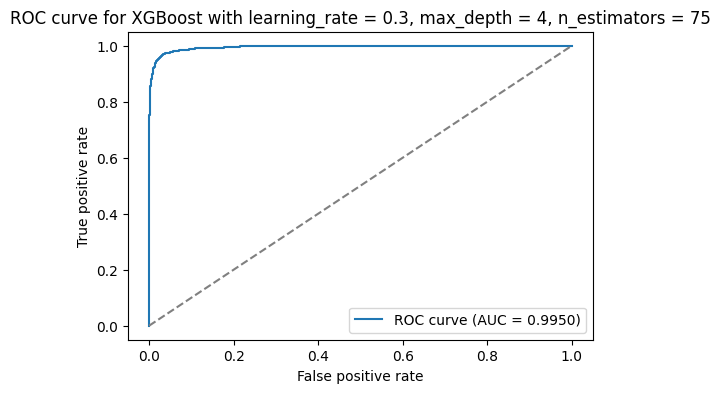

In [97]:
# Predict the probabilities of the positive class on the test set.
y_proba = grid_search.predict_proba(X_test1)[:, 1]
# Add AUC data to model comparison dataset
model_comparison.iloc[-1, model_comparison.columns.get_loc('AUC')]  = [roc_auc_score(y_test1, y_proba)]
# Plot ROC curve and AUC
ROC_AUC(y_proba, y_test1, f"ROC curve for XGBoost with learning_rate = {grid_search.best_params_['learning_rate']}, "
        f"max_depth = {grid_search.best_params_['max_depth']}, "
        f"n_estimators = {grid_search.best_params_['n_estimators']}")

Marginally worse performance is seen after hyperparameter tuning with GridSearchCV. This is similar as to was seen with the minimal dataset and is likely due to the differences in training the models using crossfold validaiton for GridSearchCV vs the train data set for the 'off-the-shelf' model.

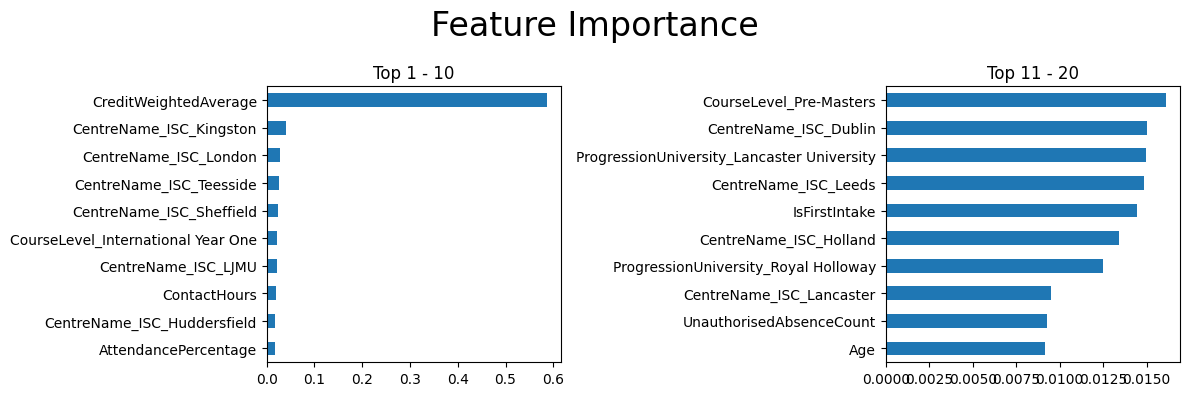

In [98]:
feature_importance = pd.Series(grid_search.best_estimator_.feature_importances_,
                               index=X_train1.columns).sort_values()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
feature_importance.iloc[-10:].plot.barh(ax=axes[0], title = 'Top 1 - 10')
feature_importance.iloc[-20:-10].plot.barh(ax=axes[1], title = 'Top 11 - 20')
fig.suptitle('Feature Importance', fontsize=24)
fig.tight_layout()
plt.show()


As can be seen, CreditWeightedAverage has a disproportionate influence on the classification compared to the other features. The next four features originated from the CentreName features. It is noted that CentreName is significantly more dominant in the feature importance than ProgressionUniverisity. If these features do exhibit some collinearity, as visually suggested above. It may be possible to reduce these two dimensions into one, reducing model complexity. Other features occuring in the top 10 are what would be expected from poor student completion, namely ContactHours and AttendancePercentage.

# Neural Network Model

## Neural Network Model with the Minimal Dataset

Here, a neural network will be used to classify the Study Group data CentreName, Gender, CourseLevel, IsFirstIntake, CreditWeightedAverage, ProgressionUniversity, UnauthorisedAbsenceCount, and Age Features.

The dataset used for training and testing the XGBoost model with the minimal dataset will be used again for this neural network model.


In [100]:
# Train the model on the minimal dataset
history = train_model(create_model(dim= X_train2.shape[1],
                                   neurons = 45),
                      X_train=X_train2,
                      y_train=y_train2,
                      X_val=X_val2,
                      y_val=y_val2)

Text(0, 0.5, 'Accuracy')

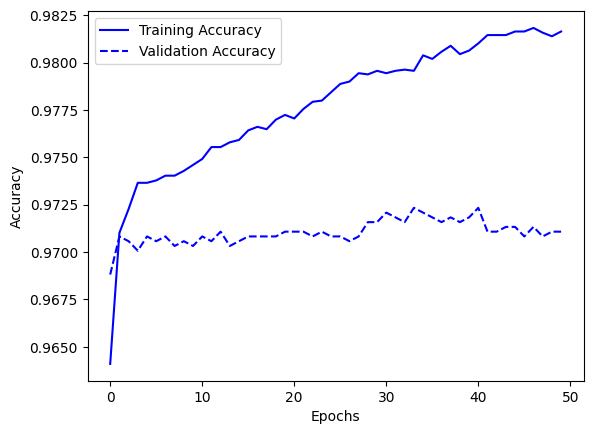

In [101]:
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'],
         label='Validation Accuracy',
         color='blue',
         linestyle='--')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

From the plot above, training the model with about five epochs would seem sensible, as overfitting seems to occur beyond this. Using this model, we get the baseline metrics shown below.

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0     0.9849    0.9802    0.9825      4249
           1     0.8868    0.9114    0.8989       722

    accuracy                         0.9702      4971
   macro avg     0.9358    0.9458    0.9407      4971
weighted avg     0.9706    0.9702    0.9704      4971



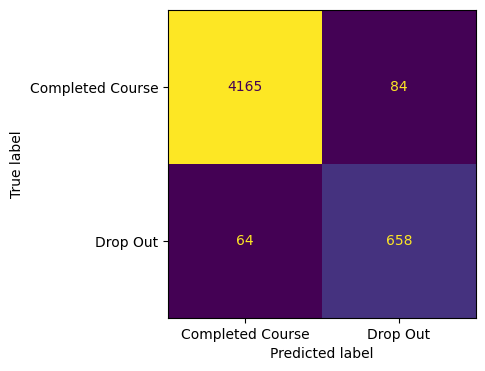

,Model,Accuracy,Precision,Recall,f1,AUC
0,XGBoost Model Minimal Dataset,0.972038,0.921852,0.882271,0.901628,0.989852
1,XGBoost Model Minimal Dataset with Tuning,0.971837,0.929204,0.872576,0.900000,0.990987
2,XGBoost Model Extended Dataset,0.979883,0.945559,0.914127,0.929577,0.994922
3,XGBoost Model Extended Dataset with Tuning,0.978475,0.942446,0.907202,0.924488,0.994979
4,Neural Network Model Minimal Dataset,0.970227,0.886792,0.911357,0.898907,NaN


In [102]:
# Fit the model on the whole  of the minimal training dataset with 5 epochs
model_nn = create_model(dim=X_train2.shape[1], optimizer='Adam')
model_nn.fit(X_train2, y_train2, epochs=5, batch_size=32, verbose=0)
predictions = model_nn.predict(X_test2)
predictions = (predictions > 0.5).astype(int)
# Plot confustion matrix and performance metrics
model_comparison = performance_metric(y_test2, predictions, "Neural Network Model Minimal Dataset", model_comparison)

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


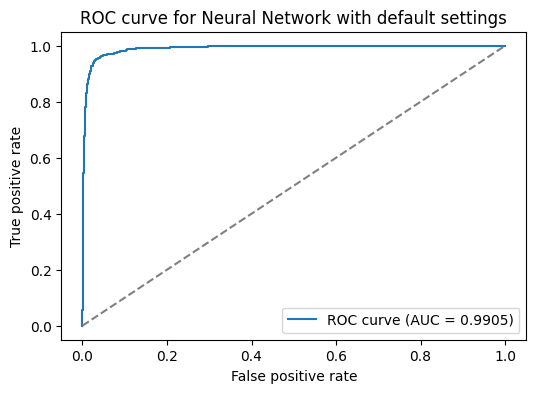

In [107]:
# Predict the probabilities of the positive class on the test set.
y_proba = model_nn.predict(X_test2)
# Add AUC data to model comparison dataset
model_comparison.iloc[-1, model_comparison.columns.get_loc('AUC')]  = [roc_auc_score(y_test2, y_proba)]
# Plot ROC curve and AUC
ROC_AUC(y_proba,
        y_test2,
        'ROC curve for Neural Network with default settings')

Initial metrics for the neural network model are worse than the XGBoost model for all metrics apart from recall and AUC. However, both of these are important for correct prediction of dropout rates.

### Tuning of the Hyperparameters with the Minimal Dataset

Here, the neural network model's hyperparameters will be tuned using GridSearchCV.

Best set of hyperparameters:  {'model__activation': 'relu', 'model__neurons': 120, 'model__optimizer': 'adam'}
Best score:  0.8981894369328987
              precision    recall  f1-score   support

           0     0.9881    0.9743    0.9812      4249
           1     0.8604    0.9307    0.8942       722

    accuracy                         0.9680      4971
   macro avg     0.9243    0.9525    0.9377      4971
weighted avg     0.9695    0.9680    0.9685      4971



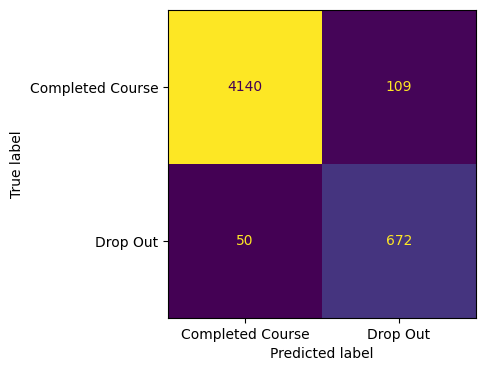

,Model,Accuracy,Precision,Recall,f1,AUC
0,XGBoost Model Minimal Dataset,0.972038,0.921852,0.882271,0.901628,0.989852
1,XGBoost Model Minimal Dataset with Tuning,0.971837,0.929204,0.872576,0.900000,0.990987
2,XGBoost Model Extended Dataset,0.979883,0.945559,0.914127,0.929577,0.994922
3,XGBoost Model Extended Dataset with Tuning,0.978475,0.942446,0.907202,0.924488,0.994979
4,Neural Network Model Minimal Dataset,0.970227,0.886792,0.911357,0.898907,0.990541
5,Neural Network Model Minimal Dataset with Tuning,0.968014,0.860435,0.930748,0.894212,NaN


In [108]:
# Define the hyperparameter grid
param_grid = {
    'model__neurons': [20, 40, 60, 90, 120, 150], # Pass 'neurons' as a parameter to the model
    'model__optimizer': ['adam', 'rmsprop'],
    'model__activation': ['relu', 'leaky_relu', 'tanh'],  # Pass 'activation' as a parameter to the model
}

nn_model = KerasClassifier(model=create_model_tune, input_dim=X_train2.shape[1], verbose=0)
# Early stopping callback to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create the GridSearchCV object, f1 scoring is used due to the imbalance of the
# dataset
grid_search = GridSearchCV(nn_model, param_grid, cv=9, scoring='f1')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), callbacks=[early_stop])

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

predictions = grid_search.predict(X_test2)
# Plot confustion matrix and performance metrics
model_comparison = performance_metric(y_test2, predictions, "Neural Network Model Minimal Dataset with Tuning", model_comparison)

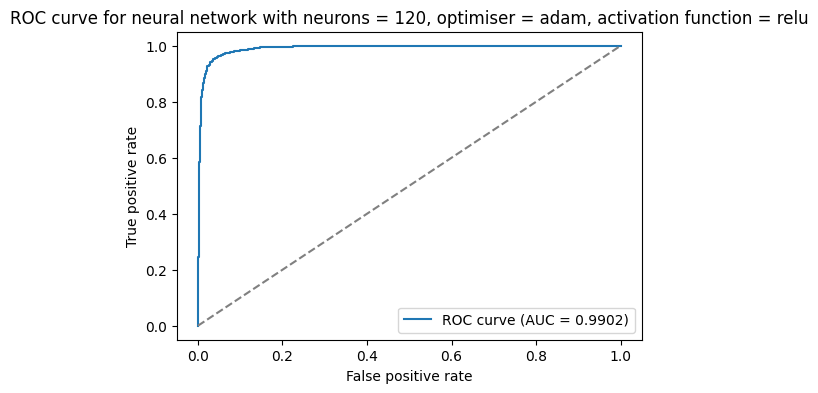

In [116]:
# Predict the probabilities of the positive class on the test set.
y_proba = grid_search.predict_proba(X_test2)[:,1]
# Add AUC data to model comparison dataset
model_comparison.iloc[-1, model_comparison.columns.get_loc('AUC')]  = [roc_auc_score(y_test2, y_proba)]
# Plot ROC curve and AUC
ROC_AUC(y_proba, y_test2, f"ROC curve for neural network with neurons = {grid_search.best_params_['model__neurons']}, "
        f"optimiser = {grid_search.best_params_['model__optimizer']}, "
        f"activation function = {grid_search.best_params_['model__activation']}")

## Neural Network Model with the Extended Dataset

Here, a neural network model will be used to classify the same Study Group data but with the inclusion of the ContactHours and AttendancePercentage features. The 'extended dataset'.

In [112]:
# The dataset used for training and testing the XGBoost model with the
# extended dataset will be used again for this neural network model.
# Train the model on the minimal dataset
history = train_model(create_model(dim= X_train1.shape[1],
                                   neurons = 47),
                      X_train=X_train1,
                      y_train=y_train1,
                      X_val=X_val1,
                      y_val=y_val1)

Text(0, 0.5, 'Accuracy')

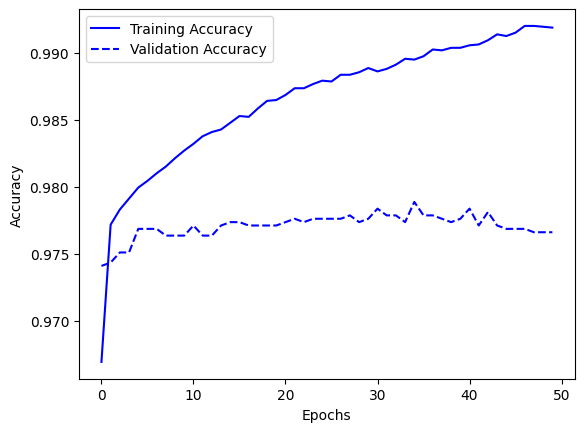

In [114]:
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'],
         label='Validation Accuracy',
         color='blue',
         linestyle='--')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

From the plot above, training the model with about five epochs would seem sensible, as overfitting seems to occur beyond this. Using this model, we get the metrics shown below.

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0     0.9864    0.9868    0.9866      4249
           1     0.9222    0.9197    0.9209       722

    accuracy                         0.9771      4971
   macro avg     0.9543    0.9532    0.9538      4971
weighted avg     0.9770    0.9771    0.9771      4971



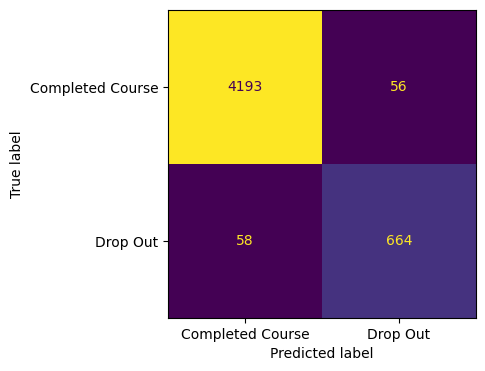

,Model,Accuracy,Precision,Recall,f1,AUC
0,XGBoost Model Minimal Dataset,0.972038,0.921852,0.882271,0.901628,0.989852
1,XGBoost Model Minimal Dataset with Tuning,0.971837,0.929204,0.872576,0.900000,0.990987
2,XGBoost Model Extended Dataset,0.979883,0.945559,0.914127,0.929577,0.994922
3,XGBoost Model Extended Dataset with Tuning,0.978475,0.942446,0.907202,0.924488,0.994979
4,Neural Network Model Minimal Dataset,0.970227,0.886792,0.911357,0.898907,0.990541
5,Neural Network Model Minimal Dataset with Tuning,0.968014,0.860435,0.930748,0.894212,0.990170
6,Neural Network Model Extended Dataset,0.977067,0.922222,0.919668,0.920943,NaN


In [115]:
# Fit the model on the whole  of the minimal training dataset with 5 epochs
model_nn = create_model(dim= X_train1.shape[1], optimizer = 'Adam')
model_nn.fit(X_train1, y_train1, epochs=5, batch_size=32, verbose=0)
predictions = model_nn.predict(X_test1)
predictions = (predictions > 0.5).astype(int)
# Plot confustion matrix and performance metrics
model_comparison = performance_metric(y_test2, predictions, "Neural Network Model Extended Dataset", model_comparison)

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


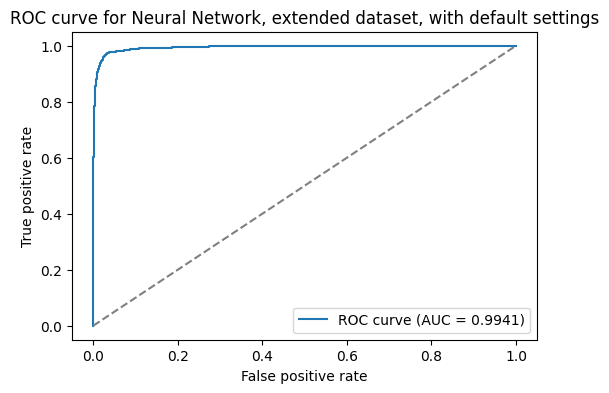

In [117]:
# Predict the probabilities of the positive class on the test set.
y_proba = model_nn.predict(X_test1)
# Add AUC data to model comparison dataset
model_comparison.iloc[-1, model_comparison.columns.get_loc('AUC')]  = [roc_auc_score(y_test1, y_proba)]
# Plot ROC curve and AUC
ROC_AUC(y_proba,
        y_test1,
        'ROC curve for Neural Network, extended dataset, with default settings')

In [118]:
model_comparison

,Model,Accuracy,Precision,Recall,f1,AUC
0,XGBoost Model Minimal Dataset,0.972038,0.921852,0.882271,0.901628,0.989852
1,XGBoost Model Minimal Dataset with Tuning,0.971837,0.929204,0.872576,0.900000,0.990987
2,XGBoost Model Extended Dataset,0.979883,0.945559,0.914127,0.929577,0.994922
3,XGBoost Model Extended Dataset with Tuning,0.978475,0.942446,0.907202,0.924488,0.994979
4,Neural Network Model Minimal Dataset,0.970227,0.886792,0.911357,0.898907,0.990541
5,Neural Network Model Minimal Dataset with Tuning,0.968014,0.860435,0.930748,0.894212,0.990170
6,Neural Network Model Extended Dataset,0.977067,0.922222,0.919668,0.920943,0.994058


### Tuning of the Hyperparameters with the Extended Dataset

Here, the hyperparameters for the neural network model will be tuned in the same manner as those used for the minimal dataset.

Best set of hyperparameters:  {'model__activation': 'relu', 'model__neurons': 120, 'model__optimizer': 'adam'}
Best score:  0.9184559773552073
              precision    recall  f1-score   support

           0     0.9858    0.9819    0.9838      4249
           1     0.8958    0.9169    0.9062       722

    accuracy                         0.9724      4971
   macro avg     0.9408    0.9494    0.9450      4971
weighted avg     0.9727    0.9724    0.9726      4971



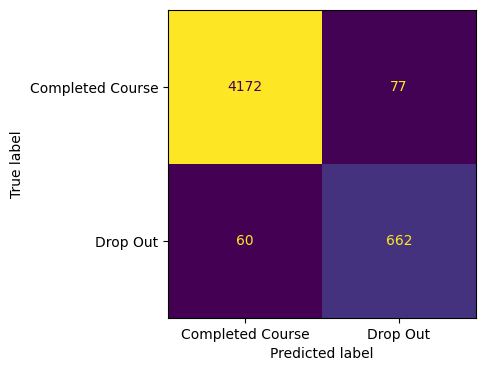

,Model,Accuracy,Precision,Recall,f1,AUC
0,XGBoost Model Minimal Dataset,0.972038,0.921852,0.882271,0.901628,0.989852
1,XGBoost Model Minimal Dataset with Tuning,0.971837,0.929204,0.872576,0.900000,0.990987
2,XGBoost Model Extended Dataset,0.979883,0.945559,0.914127,0.929577,0.994922
3,XGBoost Model Extended Dataset with Tuning,0.978475,0.942446,0.907202,0.924488,0.994979
4,Neural Network Model Minimal Dataset,0.970227,0.886792,0.911357,0.898907,0.990541
5,Neural Network Model Minimal Dataset with Tuning,0.968014,0.860435,0.930748,0.894212,0.990170
6,Neural Network Model Extended Dataset,0.977067,0.922222,0.919668,0.920943,0.994058
7,Neural Network Model Extended Dataset with Tuning,0.972440,0.895805,0.916898,0.906229,NaN


In [119]:
# Define the hyperparameter grid
param_grid = {
    'model__neurons': [20, 40, 60, 90, 120, 150], # Pass 'neurons' as a parameter to the model
    'model__optimizer': ['adam', 'rmsprop'],
    'model__activation': ['relu', 'leaky_relu', 'tanh'],  # Pass 'activation' as a parameter to the model
}

nn_model = KerasClassifier(model=create_model_tune, input_dim=X_train1.shape[1], verbose=0)
# Early stopping callback to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create the GridSearchCV object, f1 scoring is used due to the imbalance of the
# dataset
grid_search = GridSearchCV(nn_model, param_grid, cv=9, scoring='f1')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), callbacks=[early_stop])

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

predictions = grid_search.predict(X_test1)
# Plot confustion matrix and performance metrics
model_comparison = performance_metric(y_test2, predictions, "Neural Network Model Extended Dataset with Tuning", model_comparison)

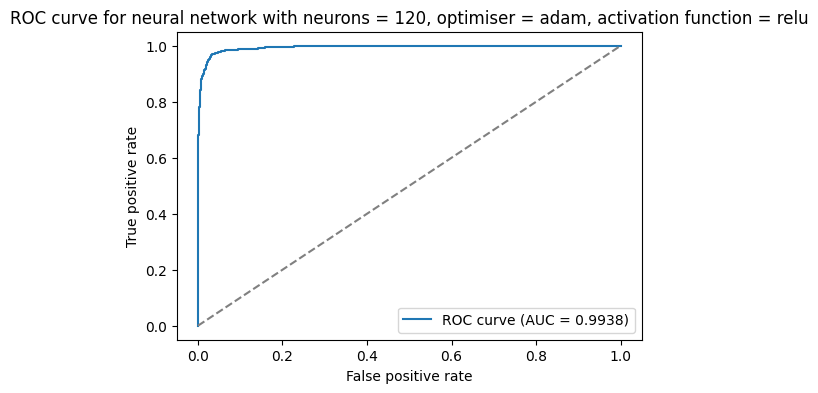

In [120]:
# Predict the probabilities of the positive class on the test set.
y_proba = grid_search.predict_proba(X_test1)[:, 1]
# Add AUC data to model comparison dataset
model_comparison.iloc[-1, model_comparison.columns.get_loc('AUC')]  = [roc_auc_score(y_test1, y_proba)]
# Plot ROC curve and AUC
ROC_AUC(y_proba, y_test1, f"ROC curve for neural network with neurons = {grid_search.best_params_['model__neurons']}, "
        f"optimiser = {grid_search.best_params_['model__optimizer']}, "
        f"activation function = {grid_search.best_params_['model__activation']}")

In [121]:
# Show results from all models
model_comparison

,Model,Accuracy,Precision,Recall,f1,AUC
0,XGBoost Model Minimal Dataset,0.972038,0.921852,0.882271,0.901628,0.989852
1,XGBoost Model Minimal Dataset with Tuning,0.971837,0.929204,0.872576,0.900000,0.990987
2,XGBoost Model Extended Dataset,0.979883,0.945559,0.914127,0.929577,0.994922
3,XGBoost Model Extended Dataset with Tuning,0.978475,0.942446,0.907202,0.924488,0.994979
4,Neural Network Model Minimal Dataset,0.970227,0.886792,0.911357,0.898907,0.990541
5,Neural Network Model Minimal Dataset with Tuning,0.968014,0.860435,0.930748,0.894212,0.990170
6,Neural Network Model Extended Dataset,0.977067,0.922222,0.919668,0.920943,0.994058
7,Neural Network Model Extended Dataset with Tuning,0.972440,0.895805,0.916898,0.906229,0.993784


Marginally worse performance is seen after hyperparameter tuning with GridSearchCV. This is similar as to was seen with the XGBoost and is likely due to the differences in training the models using crossfold validaiton for GridSearchCV vs the train data set for the 'off-the-shelf' model.

#Summary and Next Steps

XGBoost models consistently outperformed Neural Networks, with the XGBoost Extended Dataset (with and without tuning) achieving the highest overall metrics, including the best AUC of 99.50%. Neural Networks perform competitively on extended datasets but generally lag in precision and F1 score compared to XGBoost. However, for the recall, neural networks performed better. This is important and needs to be considered if we are accurately trying to catch student dropouts before they occur. Tuning had mixed effects, slightly improving AUC but often trading off recall and precision, especially for Neural Networks.

However, the differences between the two models were marginal, and the XGBoost model is preferable due to its lower computational complexity and better interpretability.  

Further work on student dropout prediction should focus on:

* **Investigating missing values** - The nature of these
missing values is not random, and the fact that they are missing seems to be related to the class. This should be investigated further so that this valuable information is not lost.

* **Investigate the use of other features** - The original dataset has 35 features, not including the CompletedCourse feature, but only ten are used. Some of these features may have more predictive value than those used.

* **Investigate feature engineering** - Further to the idea above, it would also be prudent to investigate possible feature engineering and dimension reduction.   The count plots of the categorical features (Figure 3) indicated that there may be some colinearity between the CentreName and ProgressionUniversity. Reducing features to compensate for this colinearity and including features with better predictive power will help reduce model complexity and improve performance.

* **Regularisation** - This was not attempted during this work but should be investigated to reduce overfitting and improve the model's ability to handle new data.
